# WandB run data

In [49]:
import wandb
import os
import numpy as np
import seaborn as sns
import pandas as pd
sns.set(context='notebook', style='white', palette='deep', font='sans-serif', font_scale=1, color_codes=False, rc={'figure.figsize':(15, 8)})

In [45]:
group_name = "apex_small_v0_tree_and_local_conflict_baseline"
data_dir = "data"

In [3]:
run_prefix = 'wullli/flatland/'
run_ids = ["28maqwn2", "2g8ev19o", "32v0xigi"]
runs = [run_prefix + rid for rid in run_ids]

In [4]:
api = wandb.Api()

In [5]:
if not os.path.exists(data_dir + "/" + group_name):
    os.mkdir(data_dir + "/" + group_name)

In [ ]:
def get_errors(x, y, error_key):
    

In [23]:
dfs = []

for i, run in enumerate(runs):
    run = api.run(run)
    data = run.history()
    data['step'] = data.index.values
    dfs.append(data)

In [24]:
df = pd.concat(dfs)

In [30]:
df.step

0        0
1        1
2        2
3        3
4        4
      ... 
484    484
485    485
486    486
487    487
488    488
Name: step, Length: 1496, dtype: int64

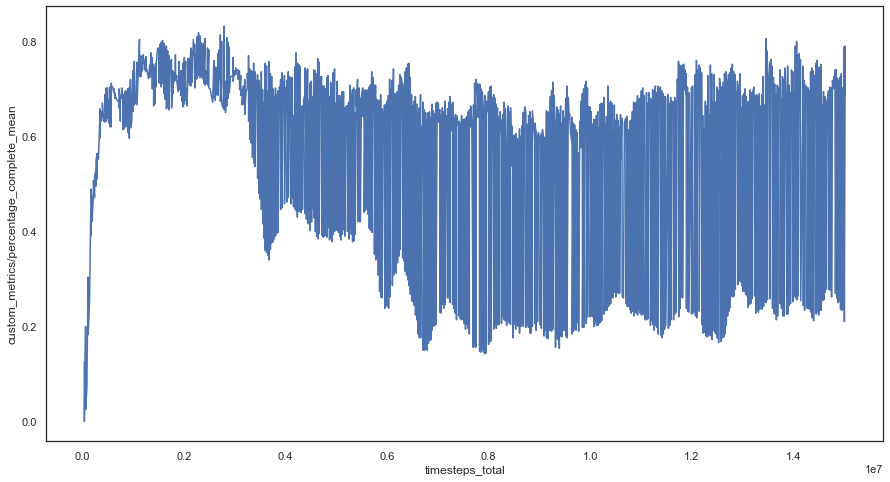

In [50]:
sns.lineplot(data=df, x="timesteps_total", y="custom_metrics/percentage_complete_mean", estimator=np.median)